# KIC 9651065

In [3]:
%run setup.py

In [5]:
t, y = np.loadtxt('../data/9651065_lc.txt', usecols=(0,1)).T

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10bbd40f0>,
      dtype=object)

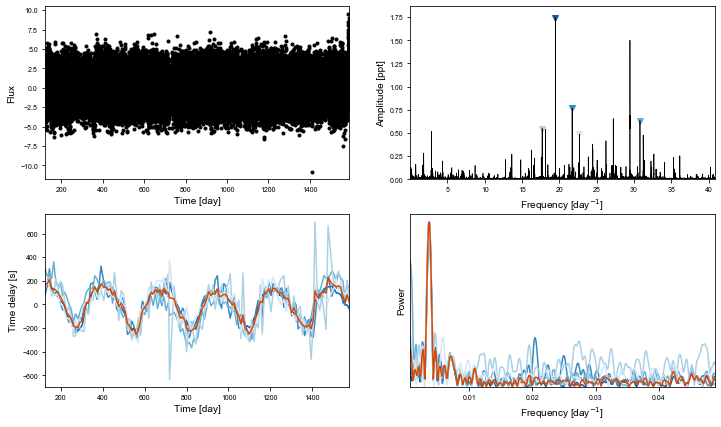

In [6]:
ms = Maelstrom(t, y, max_peaks=5, fmin=5, fmax=48)
ms.first_look()

In [8]:
period_guess = 300
a_guess = 200

time, flux = ms.time, ms.flux
freq = ms.freq
weights = ms.get_weights(norm=False)

In [5]:
pg = ms.period_search()

In [7]:
periods = np.linspace(100, 300, 300)
results = pg.fit(periods)

100%|██████████| 300/300 [10:05<00:00,  1.83s/it]


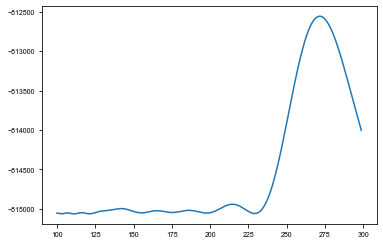

In [8]:
ys = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], sm[:-2]);

In [19]:
from maelstrom.utils import unique_colors

hh = unique_colors(len(ms.freq), cmap='Blues')

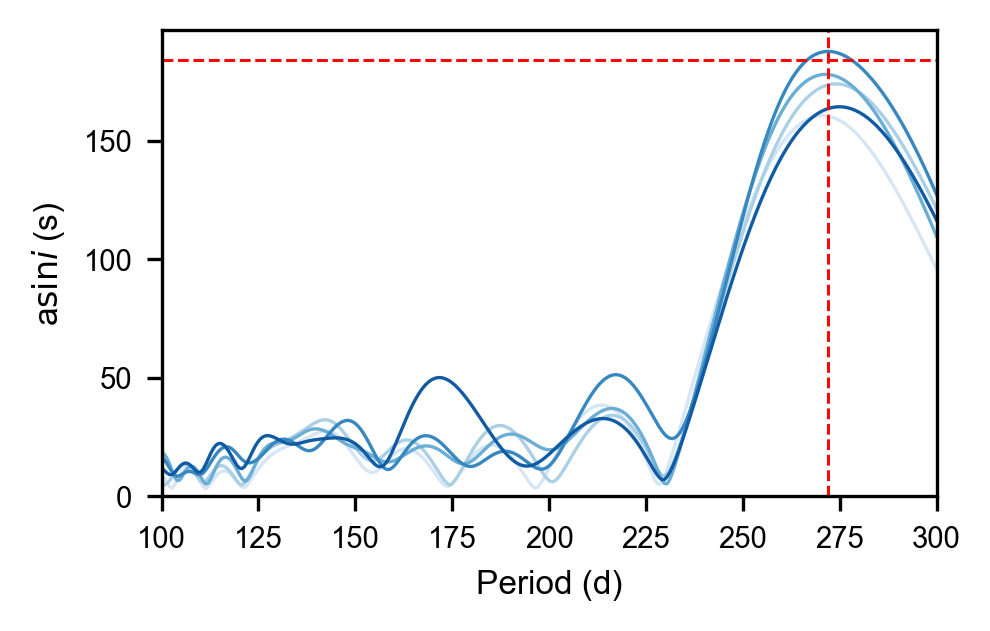

In [28]:
plt.figure(figsize=mnras_size(240.))

ys = np.array([[np.exp(r[1]["logasini"]) for r in row] for row in results])
for i, c in zip(ys, hh):
    plt.plot(periods, i, alpha=1, linewidth=0.8, c=c);

plt.xlabel('Period (d)')
plt.ylabel(r'a$\sin{i}$ (s)')
plt.ylim(0, None)
plt.xlim(100,300)
plt.axhline(184., c='r', linestyle='dashed', linewidth=0.7)
plt.axvline(272., c='r', linestyle='dashed', linewidth=0.7)

plt.savefig(overleaf_path + '9651065_period_search.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

# Maelstrom model

In [9]:
ms.setup_orbit_model(period=period_guess)
opt = ms.optimize()

In [10]:
opt

{'logperiod': array(5.60629181),
 't0': array(106.11016908),
 'varpi_angle__': array([-3.76754416,  2.40948307]),
 'eccen_interval__': array(-0.23738819),
 'logs': array(0.11242741),
 'lighttime': array([-177.17579315, -189.20818571, -196.39711643, -199.73329659,
        -181.19556313]),
 'mean_flux': array(0.00050308),
 'W_hat_cos': array([ 1.7416562 ,  0.46837105, -0.59443972,  0.54514939, -0.2793063 ]),
 'W_hat_sin': array([ 0.29248773,  0.62720114, -0.28665339, -0.1083083 ,  0.4133549 ]),
 'period': array(272.13324338),
 'varpi': array(-1.00181182),
 'eccen': array(0.44093127),
 'tref': array(22.75694516)}

In [11]:
pb1 = ms.pin_orbit_model(opt)

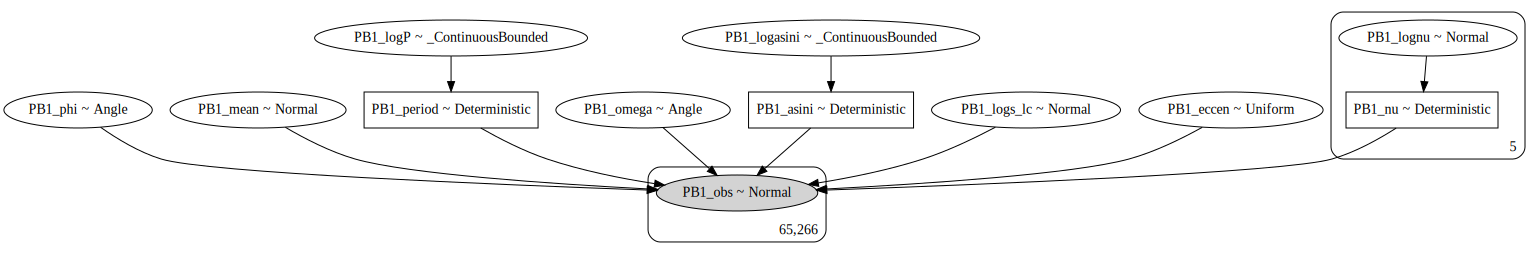

In [12]:
pm.model_to_graphviz(pb1)

In [13]:
opt = pb1.optimize()

optimizing logp for variables: [PB1_mean]
5it [00:01,  3.91it/s, logp=-1.065613e+05]
message: Optimization terminated successfully.
logp: -106561.28547089787 -> -106561.27228378068
optimizing logp for variables: [PB1_logs_lc]
9it [00:00, 20.00it/s, logp=-1.042264e+05]
message: Optimization terminated successfully.
logp: -106561.27228378068 -> -104226.40609366132
optimizing logp for variables: [PB1_omega, PB1_eccen]
50it [00:02, 20.27it/s, logp=-1.002360e+05]
message: Optimization terminated successfully.
logp: -104226.40609366132 -> -100236.02848068287
optimizing logp for variables: [PB1_phi]
68it [00:03, 21.53it/s, logp=-1.002145e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -100236.02848068287 -> -100214.47296964742
optimizing logp for variables: [PB1_lognu]
90it [00:03, 23.98it/s, logp=-1.002111e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -100214.47296964742 -> -100211.13453209169
optimizing logp for variables

In [14]:
opt

{'PB1_logP_interval__': array(1.15567803),
 'PB1_phi_angle__': array([2.23436714, 3.8739673 ]),
 'PB1_logs_lc': array(0.11245058),
 'PB1_logasini_interval__': array(1.13126088),
 'PB1_mean': array(0.00050174),
 'PB1_lognu': array([2.96926915, 3.07787135, 3.42757632, 2.87353169, 3.12211358]),
 'PB1_omega_angle__': array([ 3.73298318, -2.46270156]),
 'PB1_eccen_interval__': array(-0.00997561),
 'PB1_logP': array(5.6068392),
 'PB1_period': array(272.28224568),
 'PB1_phi': array(0.5231594),
 'PB1_logasini': array(5.22275699),
 'PB1_asini': array(185.44475011),
 'PB1_nu': array([19.47767905, 21.71213556, 30.80189831, 17.69941683, 22.69429519]),
 'PB1_omega': array(2.15397014),
 'PB1_eccen': array(0.44775551)}

In [27]:
with pb1:
    trace = pm.load_trace('traces/9651065_FINAL_VERSION2/')

In [34]:
with pb1:
    trace = pm.sample(
        tune=1000,
        draws=2000,
        start=opt,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Sampling 2 chains:   1%|          | 35/6000 [04:08<11:46:18,  7.10s/draws]


ValueError: Not enough samples to build a trace.

AttributeError: 'PB1Model' object has no attribute 'psi'

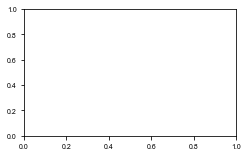

In [17]:

fig, ax = plt.subplots(figsize=mnras_size(240), constrained_layout=True)

ax.set_rasterized(True)
#ax.set_rasterization_zorder(1)

with pb1:
    for samp in xo.utils.get_samples_from_trace(trace, size=300):
        taumod = xo.eval_in_model(pb1.asini * pb1.psi, samp)
        #ttime = (ms.time_mid + time - samp['tref']) % samp['period'] / samp['period']
        ttime = (ms.time_mid + time) % samp['period'] / samp['period']
        #ttime = ((ms.time_mid + time) + (samp['phi'] * samp['period'] / (2*np.pi))) % samp['period'] / samp['period']
        sort = np.argsort(ttime)
        ax.plot(ttime[sort], (taumod - np.mean(taumod))[sort], color=blue, linewidth=0.1, alpha=0.1, 
#                 rasterized=True,
                zorder=1)
        
    

#a, b = ms.get_time_delay(segment_size=10)
#bb = np.average(b, axis=1, weights=ms.get_weights())
#plt.plot((a + ms.time_mid) % np.median(trace['period']) / np.median(trace['period']) ,bb, '.k', markersize=2)

ax.set_xlabel('Orbital phase')
ax.set_ylabel('Time delay (s)', c=blue)

ax.set_xlim(0, 1)

# plt.savefig(overleaf_path + '9651065.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
#plt.savefig('rast.pdf', dpi=300, bbox_inches='tight')

In [24]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'PB1_asini'])
mfs = mass_function(samples['period__0'].values * u.day, samples['PB1_asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

KeyError: 'period'

In [11]:
varnames=['period', 'phi', 'eccen', 'asini', 'omega', 'logw0', 'logS0']
rounding = 2
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  272.29  +  0.4  -  0.37
phi :  -0.38  +  0.06  -  0.06
eccen :  0.45  +  0.03  -  0.03
asini :  185.14  +  3.32  -  3.21
omega :  -0.99  +  0.07  -  0.07
logw0 :  0.44  +  0.02  -  0.02
logS0 :  -1.77  +  0.07  -  0.06


# Subdividing model

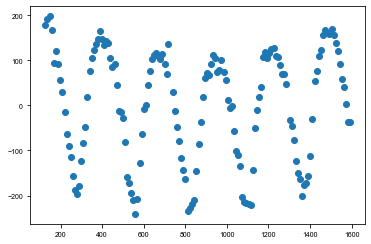

In [5]:
td_time, td_td, td_err = np.loadtxt('../data/kic9651065_uncertainties-plus-time-delay_Q99_llc.txt', delimiter=',', usecols=(0,1,2)).T
td_time += 2400000
td_time -= 2454833
plt.scatter(td_time, td_td)

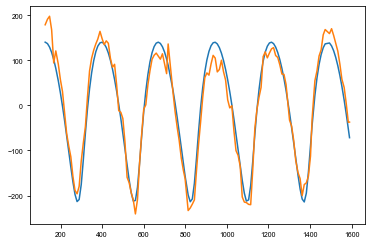

In [17]:
import theano.tensor as tt
from maelstrom.orbit import Orbit

with pm.Model() as subdivide_model:
    logP = pm.Normal("logP", mu=np.log(272), sd=1.0, testval=np.log(272))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi", testval=0.5691498)
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    logasini = pm.Normal('logasini', mu=np.log(184), sd=10, testval=np.log(184))
    asini = pm.Normal("asini", mu=184, sd=10, testval=184)
    drift = pm.Normal('drift', mu=0., sd=0.1, testval=0)
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=-0.94)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.45)
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Here, we generate an Orbit instance and pass in our priors. 
    orbit = Orbit(period=period, 
                  lighttime=asini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=0)
    
    # psi is defined to be negative but the light curve model takes 2*pi*f * (time - tau), so 
    # we must flip tau here to phase it on the same values
    td = -1*tt.squeeze(orbit.get_time_delay(td_time) * 86400) # Convert to s
    td += drift * td_time
    taumodel = pm.Deterministic('taumodel', td - tt.mean(td))
    
    pm.Normal('obs', mu=taumodel, sd=tt.exp(logs_lc), observed=td_td)
    
    plt.plot(td_time, xo.eval_in_model(taumodel))
    plt.plot(td_time, td_td)

In [18]:
with subdivide_model:
    opt = xo.optimize()

optimizing logp for variables: [mean, eccen, omega, drift, asini, logasini, logs_lc, phi, logP]
232it [00:00, 388.50it/s, logp=-6.434439e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: -48164.10895929657 -> -643.4438767879074


In [19]:
opt

{'logP': array(5.60714099),
 'phi_angle__': array([2.10553359, 3.94546931]),
 'logs_lc': array(3.23034851),
 'logasini': array(5.21493576),
 'asini': array(184.58303002),
 'drift': array(-0.01031364),
 'omega_angle__': array([-3.79526569,  2.36557775]),
 'eccen_interval__': array(0.0158198),
 'mean': array(2.38628165e-07),
 'period': array(272.36443175),
 'phi': array(0.49021052),
 'omega': array(-1.01342257),
 'eccen': array(0.45355938),
 'taumodel': array([ 147.24755677,  144.46279379,  137.15584656,  125.61074901,
         110.08619756,   90.85808226,   62.69573976,   35.92242968,
           6.16179366,  -25.77210035,  -61.20875403,  -97.26770722,
        -133.55915693, -167.94415079, -196.48908661, -212.07208628,
        -204.22591848, -167.13862369, -111.34753077,  -53.28526181,
          -1.56577971,   41.49527278,   75.96300517,  102.54463349,
         122.02595761,  134.79244776,  142.52189448,  144.40171533,
         141.41386885,  133.9053782 ,  122.17152656,  106.46937425,
 

In [20]:
with subdivide_model:
    trace = pm.sample(draws=2000, tune=2000, chains=2, start=opt)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mean, eccen, omega, drift, asini, logasini, logs_lc, phi, logP]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:44<00:00, 181.50draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [23]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logP,5.607095,0.001736,0.000027,5.603561,5.610316,3361.652808,1.000854
logs_lc,3.254204,0.059783,0.000971,3.142328,3.370083,3278.874473,1.000252
logasini,5.158147,10.329290,0.160456,-15.967711,24.618398,4166.228593,0.999801
asini,184.445995,3.870201,0.063553,176.857801,191.948600,3506.022622,0.999973
drift,-0.010248,0.005162,0.000092,-0.019934,0.000135,3809.751947,0.999920
...,...,...,...,...,...,...,...
taumodel__139,41.362412,5.391437,0.094788,30.918199,51.678708,3490.961696,1.000202
taumodel__140,11.103050,5.694254,0.098105,0.322530,22.302191,3488.877638,1.000171
taumodel__141,-19.752772,6.019379,0.100769,-32.273483,-8.936965,3567.415216,1.000086
taumodel__142,-53.100596,6.392202,0.103530,-66.166348,-41.560302,3850.340893,0.999968


In [24]:
varnames=['period', 'phi', 'eccen', 'asini', 'omega', 'phi', 'drift']
rounding = 2
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  272.35  +  0.47  -  0.46
phi :  0.49  +  0.08  -  0.08
eccen :  0.45  +  0.03  -  0.03
asini :  184.37  +  3.89  -  3.72
omega :  -1.02  +  0.08  -  0.08
phi :  0.49  +  0.08  -  0.08
drift :  -0.01  +  0.01  -  0.0


In [30]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'asini'])
mfs = mass_function(samples['period'].values * u.day, samples['asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.091  +  0.006  -  0.005


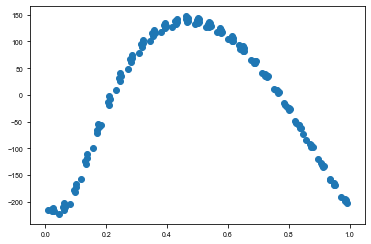

In [29]:
plt.scatter(td_time % 272 / 272, np.median(trace['taumodel'], axis=0))